In [1]:
import sys, os
import numpy as np
from tqdm import tqdm
import random
import pandas as pd
import matplotlib.pyplot as plt

local_path = '\\Users\\frank\\Online dictionnary learning spard coding\\Online-Dictionary-Learning-for-Sparse-Coding'
sys.path.append(local_path)

%load_ext autoreload
%autoreload 2
from sklearn.model_selection import train_test_split
from src.Evalution import Hyperparameter_analysis
from sklearn.preprocessing import StandardScaler
from src.Visualization.Audio import AudioVisualizer
from src.Visualization.TimeseriesVisualyzation import TimeSeriesPlotter
from src.Evalution.Reconstruction import Evaluation
from src.Dataset.Audioselection import AudioPreprocessor, AudioSplitter
from src.Model.Audio_model import DictionaryLearner, DictionaryVisualizer
from src.Dataset.Noise import NoiseAdder
from src.Visualization import TimeseriesVisualyzation

In [30]:
random.seed(100)

### I) M4 Competition Dataset:  hyperparameters and parameter's influences, Reconstruction and tuning  

#### I-1) Data set decription

The M4 Competition Dataset's "Monthly_train" subset is an extensive collection of various monthly time series data, widely used in the M4 Forecasting Competition to evaluate and advance model. It encompasses a diverse array of fields such as economics, finance, and demographics, offering a rich resource for testing time series models. With its extensive range of data sources and large volume of series, it serves as a crucial benchmarking tool in the statistical and machine learning communities for developing and refining models.

### I-2) Preprocessing

In [31]:
# Import the data set
Data = pd.read_csv("..\Dataset\Monthly_train.csv")

In [32]:
Data.shape

(48000, 2795)

In [33]:
Data.sample(5)

V1          V2          V3         V4         V5          V6  \
26544  M26545  1500.00000  1300.00000  1400.0000  1200.0000  1900.00000   
47450  M47451  1700.00000   855.00000  2000.0000   700.0000  2000.00000   
8856    M8857  7200.00000  7000.00000  8000.0000  8400.0000  8000.00000   
33485  M33486   845.00000   799.00000   937.0000   880.0000  1005.00000   
24116  M24117  5308.01738  5308.17607  5663.1683  5396.0842  5910.47284   

               V7          V8          V9         V10  ...  V2786  V2787  \
26544  2000.00000  1900.00000  1700.00000  2000.00000  ...    NaN    NaN   
47450   800.00000  2000.00000  1050.00000  1124.95000  ...    NaN    NaN   
8856   7800.00000  7800.00000  8000.00000  8500.00000  ...    NaN    NaN   
33485  1046.00000   993.00000   851.00000   999.00000  ...    NaN    NaN   
24116  5792.90959  5803.76784  5921.74266  5793.46734  ...    NaN    NaN   

       V2788  V2789  V2790  V2791  V2792  V2793  V2794  V2795  
26544    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
47450    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
8856     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
33485    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
24116    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  

[5 rows x 2795 columns]

In [34]:
# Delete column with NaN
Data.dropna(axis=1, inplace= True)

In [35]:
Data.shape 

(48000, 43)

In [36]:
# Delete the column V1 which is not number
Data.drop("V1", inplace= True, axis= 1)

##### Normalyse en split into train and test set

In [37]:
# Function to normalize each row
def normalize_row(row):
    scaler = StandardScaler()
    return scaler.fit_transform(row.values.reshape(-1, 1)).flatten()

In [38]:
# Apply the normalization to each row
Data = Data.apply(normalize_row, axis=1)

In [39]:
# Transform Data into 2D numpy array
m = Data.shape[0]
data = np.zeros((m, 42))
for i in range(m):
    data[i,:] = Data[i]

In [40]:
data.shape

(48000, 42)

After the cleaning operations, the final dataset contains 48,000 time series, each with 42 observations. We divide this dataset into a training set (80%) and a test set (20%). The training set is used for learning the dictionary and studying the impact of hyperparameters, while the test set is utilized after best hyperparameters searching, to test the ability of the dictionary learned on the training set to reconstruct other time series that are not part of the training set.

In [41]:
# Generate a list of indices corresponding to the series
indices = np.arange(data.shape[0])

# Split indices into training and testing sets
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Use the indices to create the training and testing sets
Train = data[train_indices]
Test = data[test_indices]

In [42]:
print(Train.shape)
print(Test.shape)

(38400, 42)
(9600, 42)


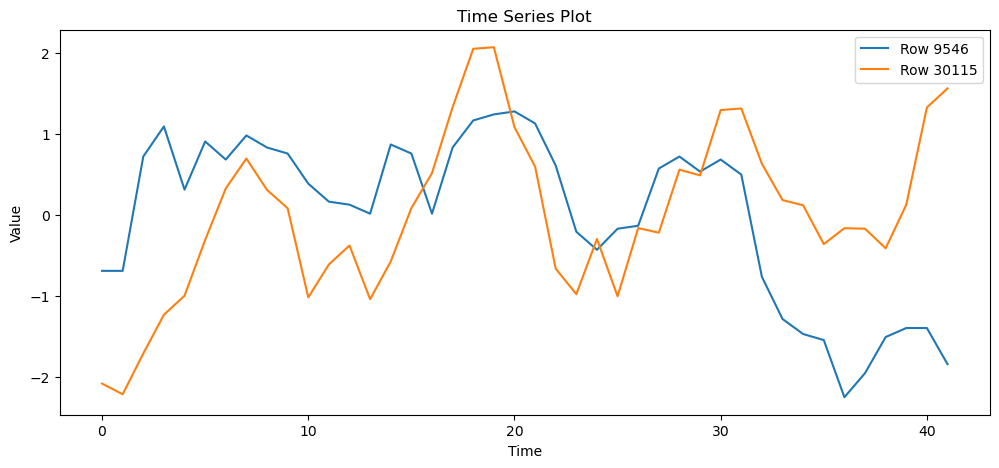

In [43]:
#display a choising number of observation
num_display = 2
index = random.sample(range(Train.shape[0]), num_display)
visualizer = TimeSeriesPlotter(Train)
visualizer.plot_indices(index)

### I-3) Impact of batch size on Objective function and training time

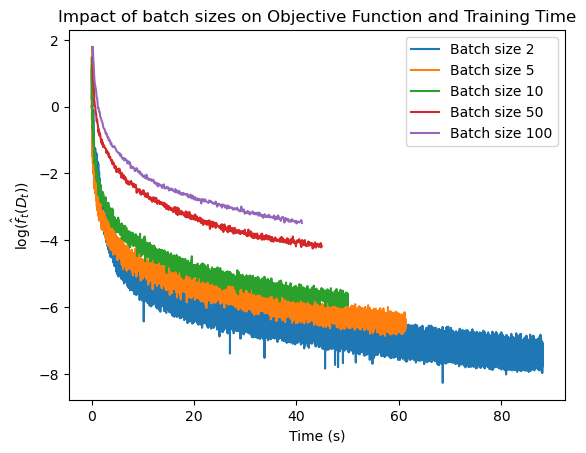

In [100]:
Hyperparameter_analysis.dictionary_learning_analysis_batch_sizes(Train, n_components = 10, 
                                                                 batch_sizes=[2, 5, 10, 50, 100])

As observed, a smaller batch size tends to result in a longer convergence time for the algorithm, while also achieving a more effective minimization of the objective function.

### I-4) Impact of penalty coefficient ($\lambda$) on Objective function and training time

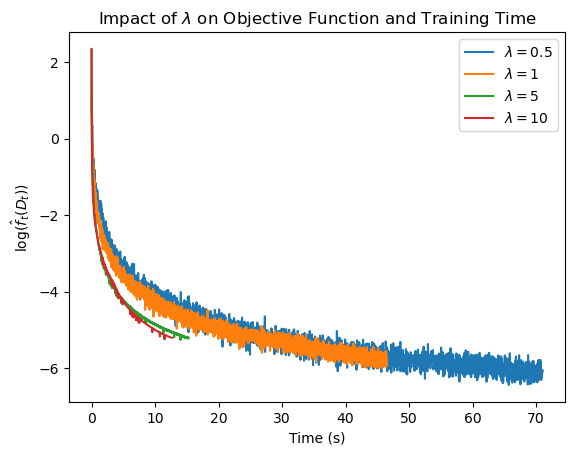

In [45]:
Hyperparameter_analysis.dictionary_learning_analysis_alphas(Train, n_components=10, 
                                                            batch_size=10, alphas=[0.5, 1, 5, 10])

It can be noted that a smaller value of the coefficient $\lambda$ leads to a longer convergence time for the algorithm. Similarly, these lower values of $\lambda$ appear to more effectively minimize the objective function.

### I-5) Impact of number of atoms on training time

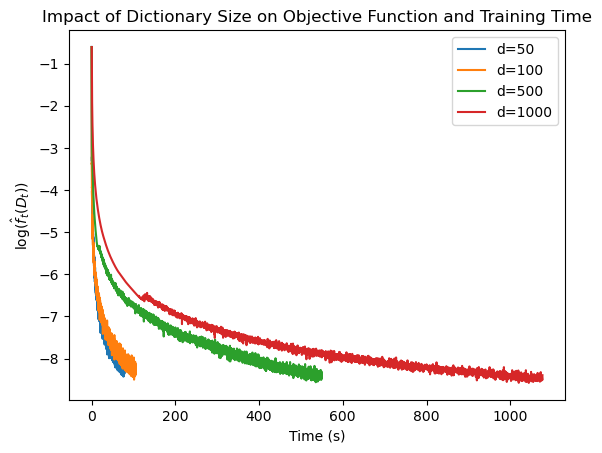

In [46]:
Hyperparameter_analysis.dictionary_learning_component_analysis(Train, batch_size=10, 
                                                               components_list=[50, 100, 500, 1000])

It is clearly observed that an increase in the number of atoms results in a longer convergence time for the algorithm. It seems like the number the nomber of atoms does not impact the optimal value of the objective function

### I-6) Impact of initialisation strategie on training time

C:\Users\frank\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


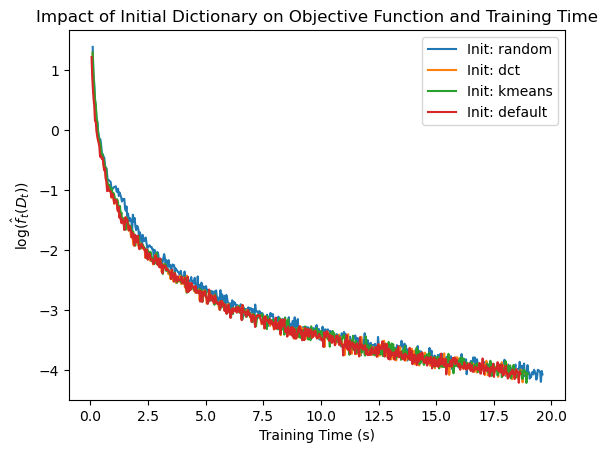

In [47]:
Hyperparameter_analysis.dictionary_learning_analysis_initial_dict(Train[:12000, :], n_components = 50, 
                                                                  batch_size = 20, alpha = 1, init_strategies = ["random", "dct", "kmeans", "default"])


There is no significant difference among these strategies in terms of reaching the optimal value of the objective function and the training time need for convergence.

The default method, which typically employs a random or heuristic-based approach; random initialization, where dictionary elements are generated stochastically; DCT (Discrete Cosine Transform) initialization, leveraging frequency components and useful for signal processing; and K-means initialization, using data-derived centroids as dictionary atoms.

### I-7) Evolution of atoms during the training

As observed in the video below, the various atoms of the dictionary undergo significant changes primarily during the initial iterations. In subsequent iterations, these atoms change very minimally, and these changes generally consist of subtle refinements and polishing of their shapes. This pattern suggests that the major structural learning of the dictionary occurs early in the process, with later iterations fine-tuning the details.

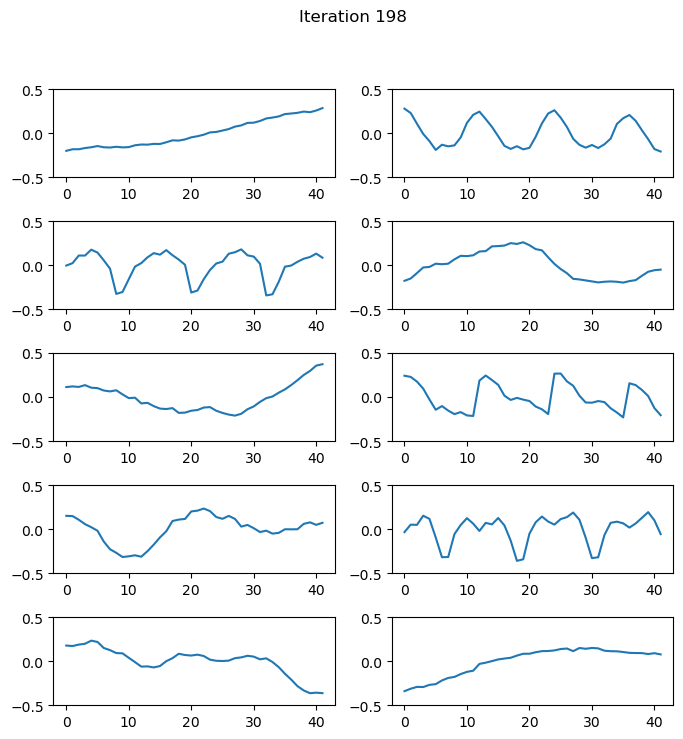

In [48]:
Hyperparameter_analysis.visualize_dictionary_evolution(Train[:2000,:], n_components= 10, batch_size=10)

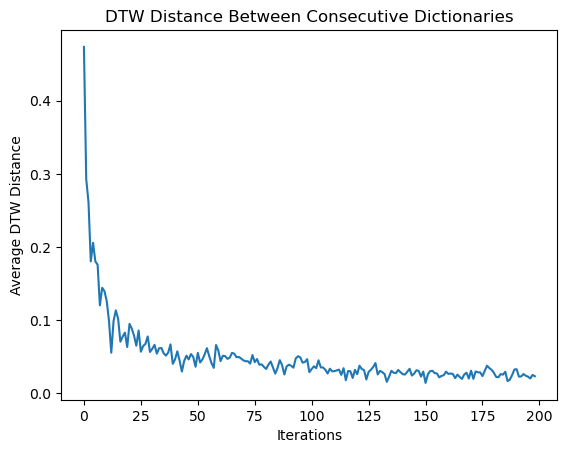

In [49]:
Hyperparameter_analysis.plot_dictionary_distance(Train[:2000], n_components=10, batch_size= 10, alpha=0.1)

To better illustrate the observation mentioned above, we evaluated the differences between successive states of the dictionary by calculating the Dynamic Time Warping (DTW) distance between consecutive states of each atom during training. As depicted in the figure below, it is evident that the major changes occur during the initial iterations, and subsequently, the atoms of the dictionary undergo only minimal, insignificant changes. This trend indicates that the primary learning and structural adjustments of the dictionary atoms happen early in the training process, while later stages involve more subtle refinements and stabilization of the dictionary's structure.

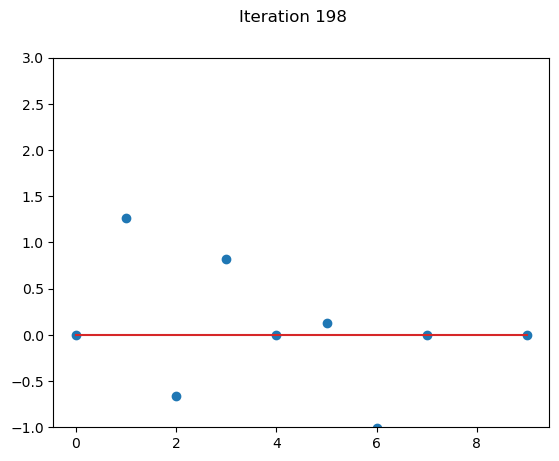

In [50]:
Hyperparameter_analysis.visualize_sample_evolution(Train[1: 2000,:], n_components=10, batch_size=10,
                                                   sample_every= 3, single_sample= Test[3,:])

This video offers a dynamic visualization that captures the evolution of a single data sample's representation through the dictionary learning process. This serves as a tool for understanding the effectiveness and behavior of the algorithm. By observing how the sample's representation changes across iterations, we gain valuable insights into the algorithm's ability to capture and refine the essential features of the data. This visualization is also particularly useful for assessing the learning dynamics, highlighting that significant learning predominantly occurs during the initial iterations. Overall, it provides a visually intuitive way to understand the complex process of dictionary learning in our study.

### I-8) Impact of number of atoms on reconstruction of a giving signal

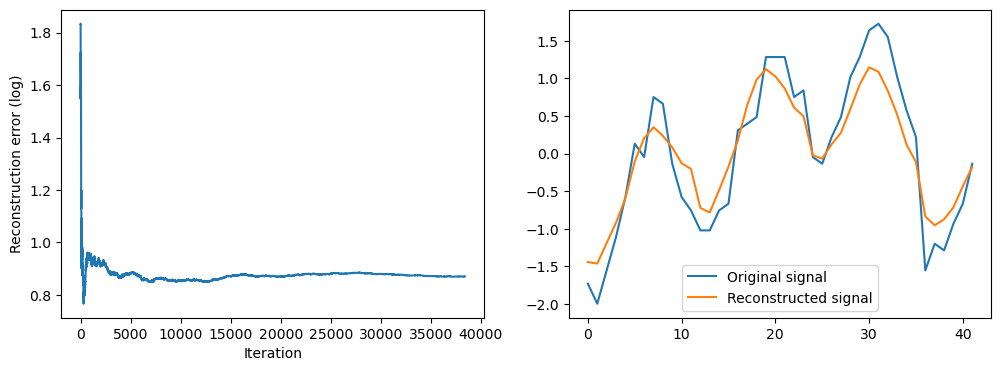

In [51]:
Hyperparameter_analysis.visualize_reconstruction(Train, n_components= 5, batch_size=1, test_sample_index=1)

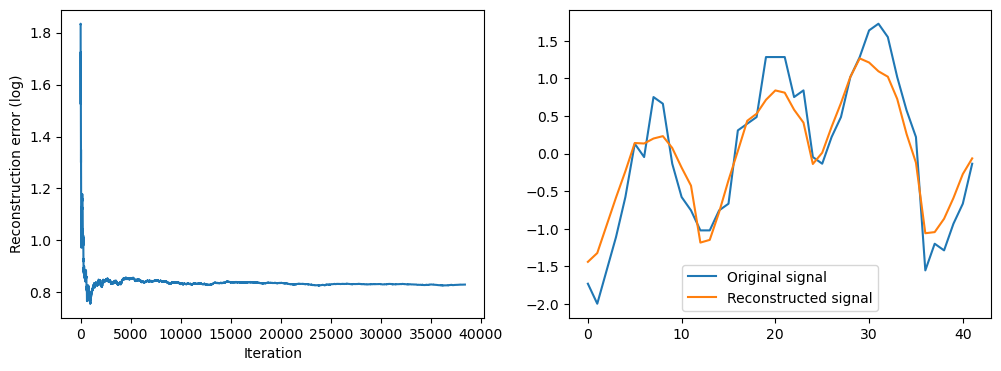

In [52]:

Hyperparameter_analysis.visualize_reconstruction(Train, n_components= 10, batch_size=1, test_sample_index=1)

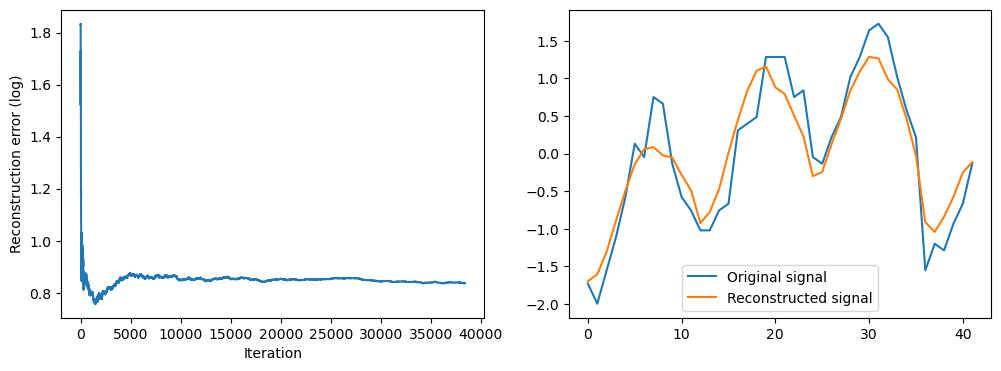

In [53]:
Hyperparameter_analysis.visualize_reconstruction(Train, n_components= 50, batch_size=1, test_sample_index=1)

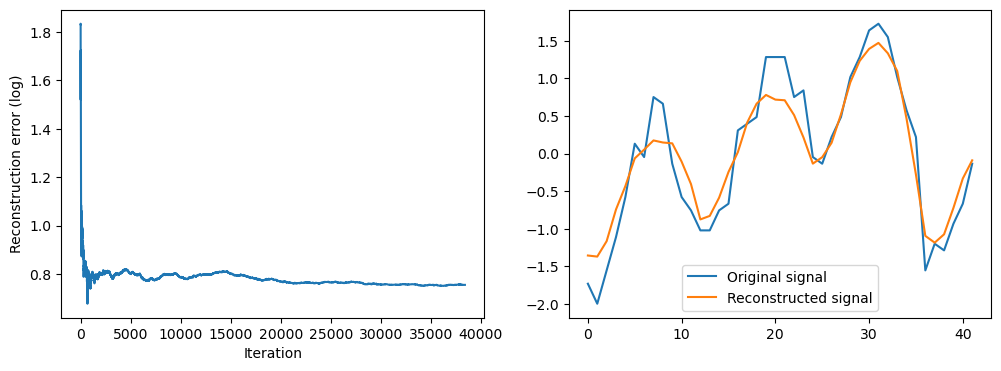

In [54]:
Hyperparameter_analysis.visualize_reconstruction(Train, n_components= 100, batch_size=1, test_sample_index=1)

It appears that the quality of reconstruction improves with an increasing number of atoms in the dictionary. To better understand this relationship, below we conduct an experiment for various dictionary sizes. For each of these sizes, we learn a dictionary and evaluate its effectiveness on the test set. The evaluation involves calculating the Dynamic Time Warping (DTW) distance between each signal in the test set and its reconstructed version. This process allows us to assess how the size of the dictionary impacts the algorithm's ability to accurately reconstruct the original time series, with DTW serving as a metric to quantify the similarity between the original and reconstructed signals.

In [55]:
alpha = 1.2/np.sqrt(42) # This value is suggested in the article

In [56]:
n_components = [2, 5, 10, 15, 20, 50, 70, 100, 150, 200, 250, 500]
errors = []
for n in n_components:
    e = Hyperparameter_analysis.evaluate_reconstruction(Train, Test, n_components = n, batch_size = 10 , alpha = alpha)
    errors.append(e)

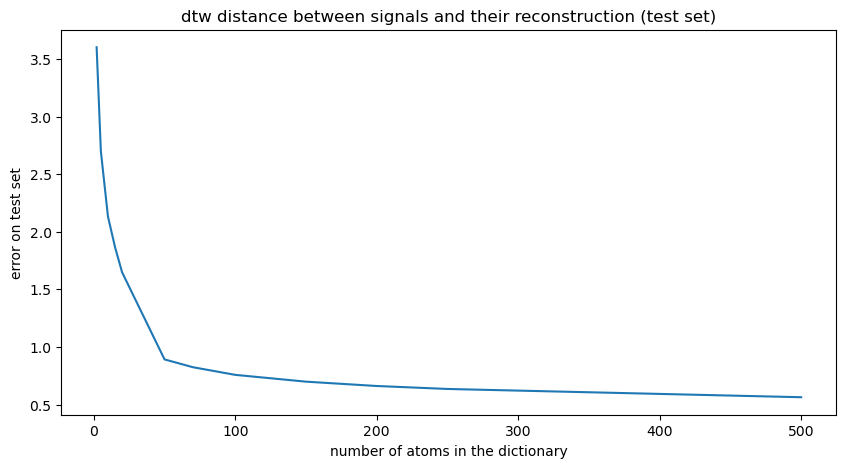

In [57]:
plt.figure(figsize = (10, 5))
plt.plot(n_components, errors)
plt.xlabel("number of atoms in the dictionary")
plt.ylabel("error on test set")
plt.title("dtw distance between signals and their reconstruction (test set)")
plt.show()

We observe that while increasing the number of atoms in the dictionary generally improves the reconstruction quality, this improvement plateaus beyond 70 atoms. Additionally, it's important to note that more atoms also result in longer training times. Therefore, while there may be marginal gains in reconstruction accuracy with more atoms, these need to be weighed against the significantly increased computational cost. This balance suggests an optimal range for the number of atoms, where the benefits in reconstruction quality are maximized relative to the computational resources required.

### I-9) Impact of batch size on reconstruction task

In [58]:
batch_size= [1, 5, 10, 15, 20, 50, 70, 100, 150, 200, 250,500]
errors = []
for n in batch_size:
    e = Hyperparameter_analysis.evaluate_reconstruction(Train, Test, n_components = 50, batch_size = n , alpha = 1.2)
    errors.append(e)

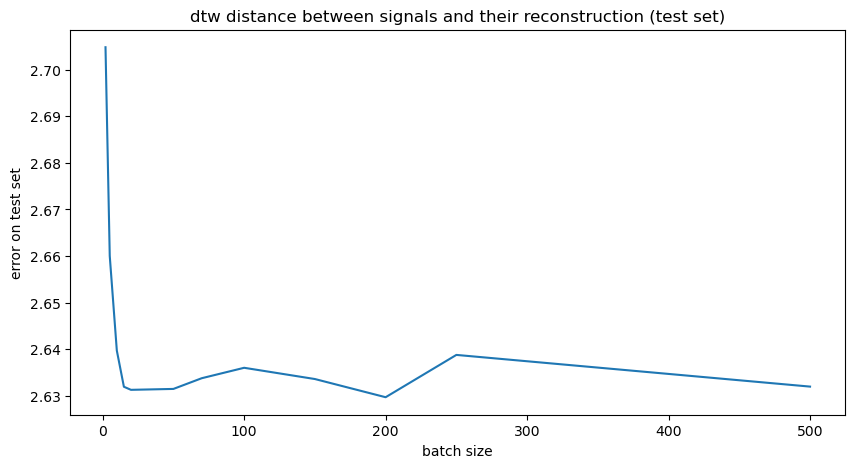

In [59]:
plt.figure(figsize = (10, 5))
plt.plot(n_components, errors)
plt.xlabel("batch size")
plt.ylabel("error on test set")
plt.title("dtw distance between signals and their reconstruction (test set)")
plt.show()

In our experiment with a range of batch sizes, we observed an improvement in reconstruction quality when , followed by a deterioration beyond this point. Interestingly, within this optimal range, the difference in reconstruction error is minimal (between 2.69 and 2.63), indicating that the batch size has a relatively minor impact on performance. This finding suggests a sweet spot for batch size in dictionary learning, where a balance is struck between processing efficiency and quality of reconstruction.

### I-10) Impact of regularization parameter $\lambda$ on reconstruction task

In [60]:
alphas = [0.5, 0.7, 0.9, 1.4, 1.7,  1.9, 2.2, 2.5, 3, 5, 10]
errors = []
for al in alphas:
    e = Hyperparameter_analysis.evaluate_reconstruction(Train, Test, n_components = 50, batch_size = 10 , alpha = al)
    errors.append(e)

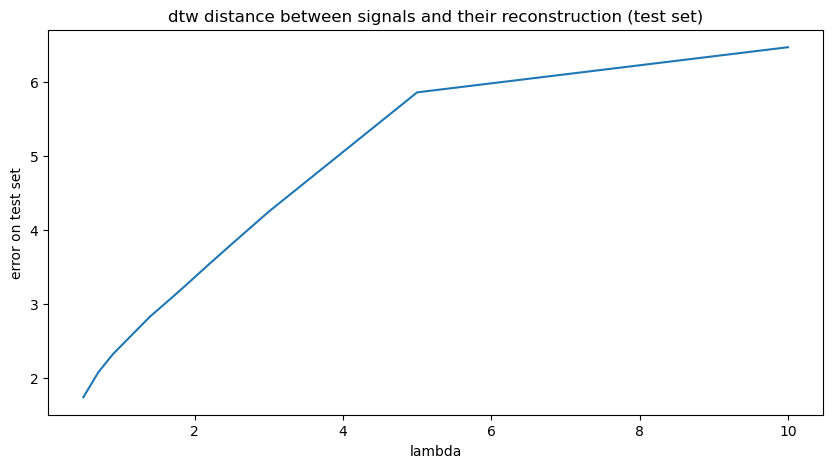

In [61]:
plt.figure(figsize = (10, 5))
plt.plot(alphas, errors)
plt.xlabel("lambda")
plt.ylabel("error on test set")
plt.title("dtw distance between signals and their reconstruction (test set)")
plt.show()

In a similar experiment with varying values of the regularization parameter $\lambda$ , we observed a clear trend: the smaller the $\lambda$, the better the reconstruction quality. The error notably increased with larger $\lambda$ values, ranging from 1.7 to 6. This indicates that a lower $\lambda$ value, which implies less regularization, tends to yield more accurate reconstructions.

### I-11) Grid search for tuning hyperparameters for reconstruction task

In [62]:

n_components = 70
batch_sizes = [1, 5, 10, 50, 70, 100] 
alphas = [0.1,al, 0.5, 1]   

best_params, best_error = Hyperparameter_analysis.grid_search(Train, Test, n_components, batch_sizes, alphas)
print("Meilleurs paramètres :", best_params)
print("Erreur de reconstruction minimale :", best_error)

Meilleurs paramètres : {'n_components': 70, 'batch_size': 70, 'alpha': 0.1}
Erreur de reconstruction minimale : 0.49353096941714586


In [63]:
learner = DictionaryLearner(n_components= 70, alpha= 0.1, max_iter= 10000, batch_size= 50)
dictionary = learner.fit(Train)
Reconstructor = Evaluation(dictionary)

### I - 12) Display reconstruction for 4 signals from **Train set**

In [64]:
# Randomly select 4 time series in train set and compute their reconstruction version
index = random.sample(range(Train.shape[0]), 4)
signals = []
reconstrutions = []
for i in  index :
    reconstrutions.append(Reconstructor.reconstruct_signal(Train[i,:]))
    signals.append(Train[i,:])

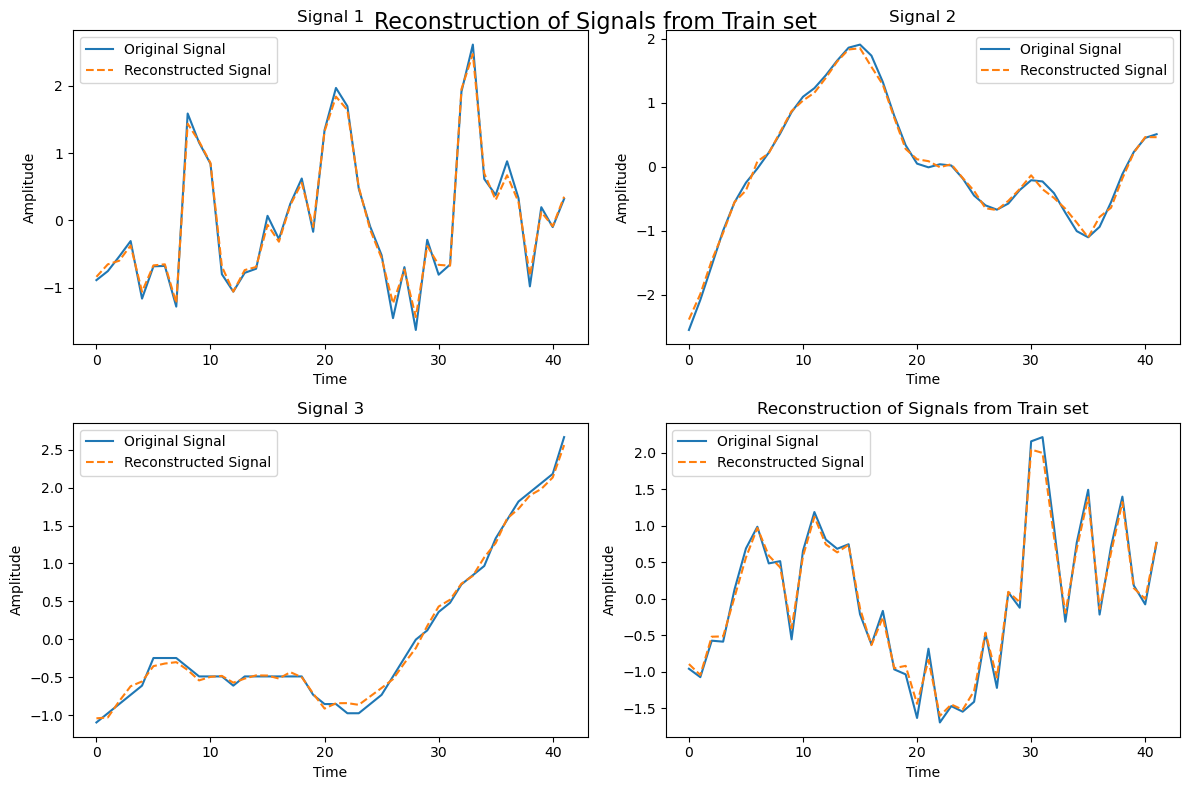

In [65]:

titles = ['Signal 1', 'Signal 2', 'Signal 3', 'Signal 4']
TimeseriesVisualyzation.plot_signals_and_reconstructions(signals, reconstrutions, titles,
                                                         title="Reconstruction of Signals from Train set")

###  I - 13) Display reconstruction for 4 signals from Test set

In [66]:
# Randomly select 4 time series in test set and compute their reconstruction version
index = random.sample(range(Test.shape[0]), 4)
signals = []
reconstrutions = []
for i in  index :
    reconstrutions.append(Reconstructor.reconstruct_signal(Test[i,:]))
    signals.append(Test[i,:])

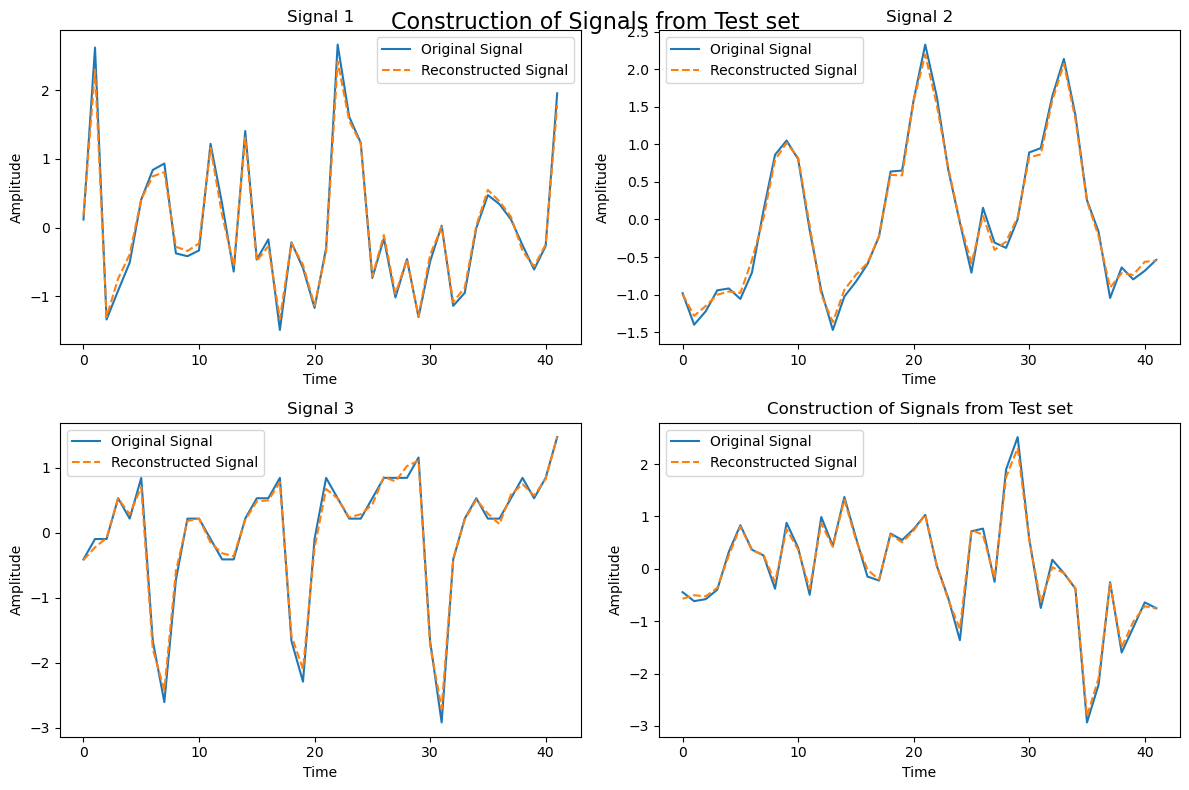

In [67]:
titles = ['Signal 1', 'Signal 2', 'Signal 3', 'Signal 4']
TimeseriesVisualyzation.plot_signals_and_reconstructions(signals, reconstrutions, titles
                                                         , title="Construction of Signals from Test set")

The observed improvement in signal reconstruction, both in the training and test sets, following a grid search, underscores the efficacy of carefully tuning hyperparameters process. By selecting optimal values for parameters, the algorithm has been fine-tuned to more accurately capture and reconstruct the underlying patterns in the data. The notably better reconstruction of randomly chosen signals from both sets indicates that the model, with its optimized hyperparameters, is not only effective in learning from the training data but also generalizes well to unseen data in the test set. 

### II) Mozilla Common Voice and UrbanSound8K Dataset: speech denoising and reconstruction 

In our audio reconstruction and denoising study, we employed the Mozilla Common Voice (MCV) Dataset for its diverse range of voice recordings and the UrbanSound8K Dataset for its variety of urban noises. MCV's wide array of accents and dialects is ideal for speech reconstruction, while UrbanSound8K's urban sound samples are well-suited for denoising and audio restoration tasks. Together, these datasets offer a rich resource for developing and refining audio processing techniques.

 I use this code to split the dataset into train and test

In [68]:
'''base_path = 'C:\\Users\\frank\\Online dictionnary learning spard coding\\data\\cv-corpus-15.0-delta-2023-09-08\\en\\clips'
splitter = AudioSplitter(base_path)
splitter.split()'''

"base_path = 'C:\\Users\\frank\\Online dictionnary learning spard coding\\data\\cv-corpus-15.0-delta-2023-09-08\\en\\clips'\nsplitter = AudioSplitter(base_path)\nsplitter.split()"

#### II-1) Select video and preprocess them to learn the dictionnary

In [57]:
directory_path = 'C:\\Users\\frank\\Online dictionnary learning spard coding\\data\\cv-corpus-15.0-delta-2023-09-08\\en\\clips\\train_set'
num_samples = 100 
# Remove silence, Apply STFT and then inverse STFT
# Truncate or extend the audio to match the target length, Normalize the signal
preprocessor = AudioPreprocessor(directory_path, num_samples, target_duration=2)
preprocessed_audios = preprocessor.preprocess_all()


#### II-2) Use gridsearch to find suitable parameters

In the context of speech processing, we opt to use the L2 norm due to the computational cost associated with calculating DTW (Dynamic Time Warping). The L2 norm, being simpler and faster to compute, offers a more efficient alternative for evaluating reconstruction quality in speech-related tasks.

In [58]:
def calculate_L2_error(original_signal, reconstructed_signal):
    alignment = np.linalg.norm(original_signal - reconstructed_signal)
    return alignment

In [59]:
param_grid = {
    'n_components': [20],
    'alpha': [0.5, 1, 2, 3],
    'batch_size': [20]
}


In [60]:
best_params = None
best_error = float('inf')

# Iterating over the parameter grid
for n_components in param_grid['n_components']:
    for alpha in tqdm(param_grid['alpha']):
            for batch_size in param_grid['batch_size']:
                # Initialize and train the DictionaryLearner
                learner = DictionaryLearner(n_components=n_components, alpha=alpha, max_iter= 2000, batch_size=batch_size)
                dictionary = learner.fit(preprocessed_audios)

                # Evaluate the dictionary using DTW error
                evaluator = Evaluation(dictionary)
                total_error = 0
                for signal in preprocessed_audios:
                    reconstructed_signal = evaluator.reconstruct_signal(signal)
                    total_error += calculate_L2_error(signal, reconstructed_signal)

                avg_error = total_error / len(preprocessed_audios)

                
                # Update best parameters
                if avg_error < best_error:
                    best_error = avg_error
                    best_params = {'n_components': n_components, 'alpha': alpha,  'batch_size': batch_size}

print(f"Best Parameters: {best_params}, Best Error: {best_error}")


100%|██████████| 4/4 [09:14<00:00, 138.53s/it]

Best Parameters: {'n_components': 20, 'alpha': 2, 'batch_size': 20}, Best Error: 26.892550697922708


In [61]:
print(f"The best parameters are {best_params}")
print(f"The corresponding L2 norm between the reconstructed and original signals is {best_error}")

The best parameters are {'n_components': 20, 'alpha': 2, 'batch_size': 20}
The corresponding L2 norm between the reconstructed and original signals is 26.892550697922708


Use those parameters to learn dictionnary

In [62]:
learner = DictionaryLearner(n_components=best_params["n_components"], alpha=best_params["alpha"], max_iter=2000,
                             batch_size= best_params["batch_size"])
dictionary = learner.fit(preprocessed_audios)



Display some atoms, you can view all of them if you want, it just makes the notebook too long

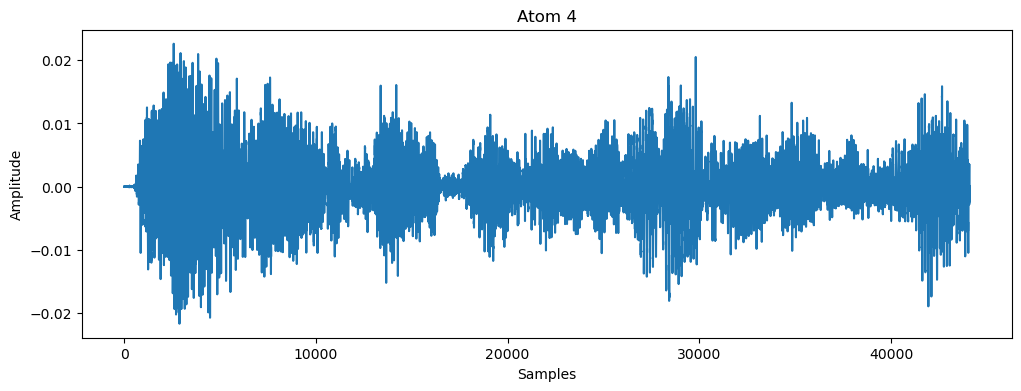

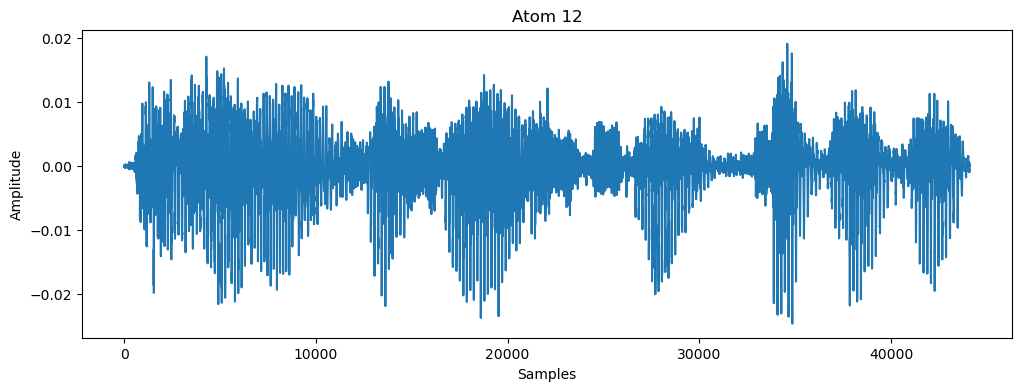

In [63]:
# Randonly select "number_dic" of atoms and display them
number_dic = 2
visualizer = DictionaryVisualizer(dictionary, sample_rate=22050, number_dic = number_dic)
visualizer.show_all_atoms()

We observe that the dictionary atoms have not memorized certain specific audio samples.

In [64]:
# select best reconstructed signals
Reconstructor = Evaluation(dictionary)
best_signal_reconstruted = []

for i in range(len(preprocessed_audios)):
    reconstructed_signal = Reconstructor.reconstruct_signal(preprocessed_audios[i])
    distance = calculate_L2_error(preprocessed_audios[i], reconstructed_signal)
    if distance <  5: 
        best_signal_reconstruted.append(i)

### II-3) Reconstruction task: signal part of train set
 

The original signal 98


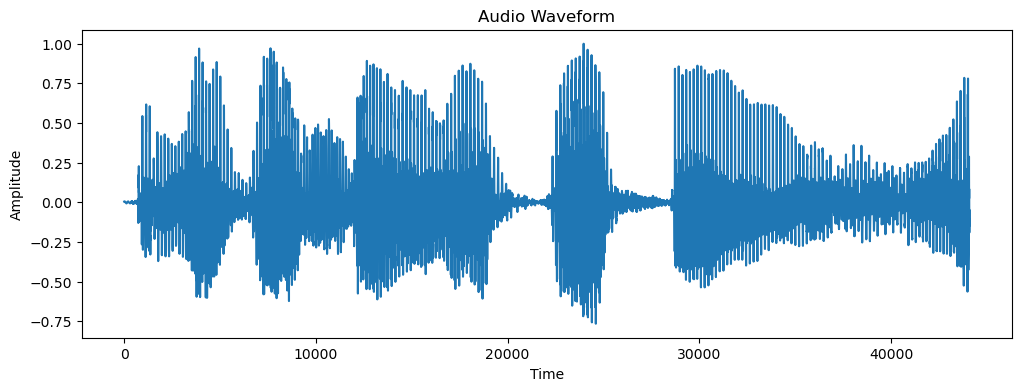

The reconstruction version of 98


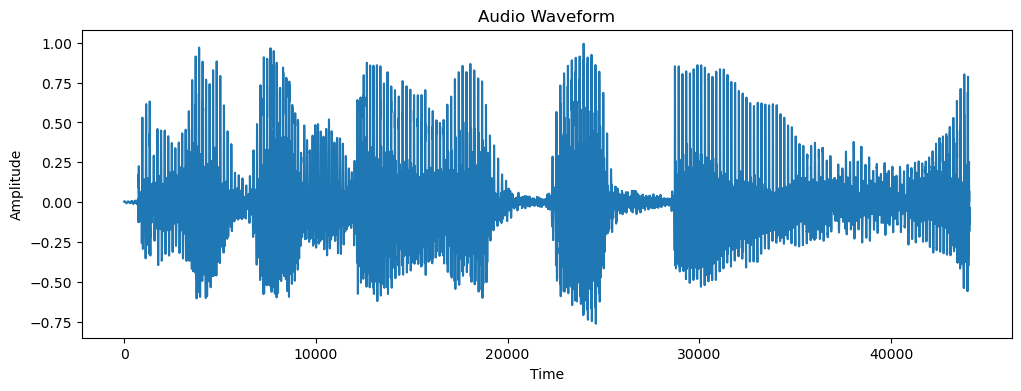



The original signal 95


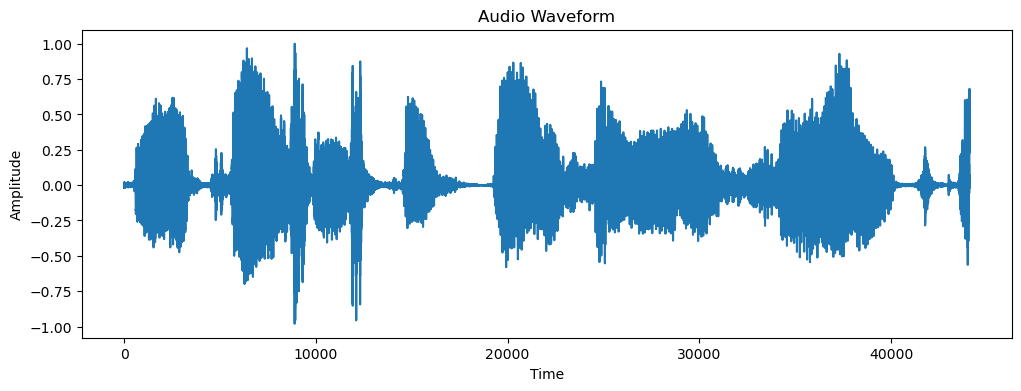

The reconstruction version of 95


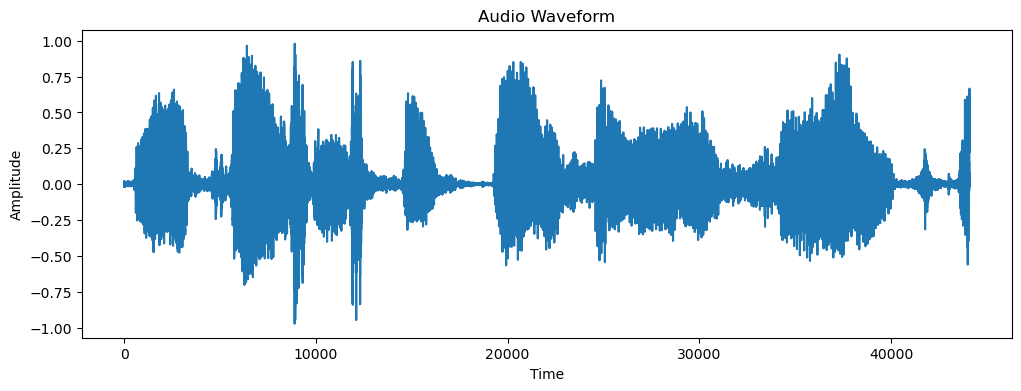

In [65]:
# Randomly select "num_display" of audio display them and their reconstruction versions
num_display = 2
for i in random.sample(best_signal_reconstruted, number_dic):
    reconstructed_signal = Reconstructor.reconstruct_signal(preprocessed_audios[i])
    print(f"The original signal {i}")
    visualizer = AudioVisualizer(preprocessed_audios[i])
    visualizer.show()
    print(f"The reconstruction version of {i}")
    visualizer = AudioVisualizer(reconstructed_signal)
    visualizer.show()
    print("")
    print("")
    

In [66]:
len(best_signal_reconstruted)

16

It is observed that the reconstruction of signals from the training set is exceptionally good, to the extent that the spoken words in the reconstructed signal are as clear and intelligible as in the original signal. This indicates a high level of fidelity in the reconstruction process, effectively preserving the essential characteristics and quality of the original speech.

### II-4) Denoising task:  signal part of train set

In our study, we introduced an additional challenge by adding dog barking noises to a selection of audio signals, chosen arbitrarily from our dataset. This step was aimed at simulating real-world scenarios where audio recordings often contain background noise. Following the introduction of noise, we utilized the dictionary we had learned earlier to attempt denoising these audio signals. This process involved applying the dictionary to filter out the unwanted noise (in this case, the barking of dogs) while striving to retain the clarity and integrity of the original audio. The effectiveness of this approach was then evaluated to assess how well the learned dictionary could isolate and remove extraneous sounds from the noisy audio signals.

In [67]:
noise_adder = NoiseAdder('C:\\Users\\frank\\Online dictionnary learning spard coding\\data\\UrbanSound8K\\UrbanSound8K\\audio\\fold1')

#### A) Add different noises to different signals

We introduced a variety of noises to different audio signals to simulate diverse auditory disturbances

Original Signal 27


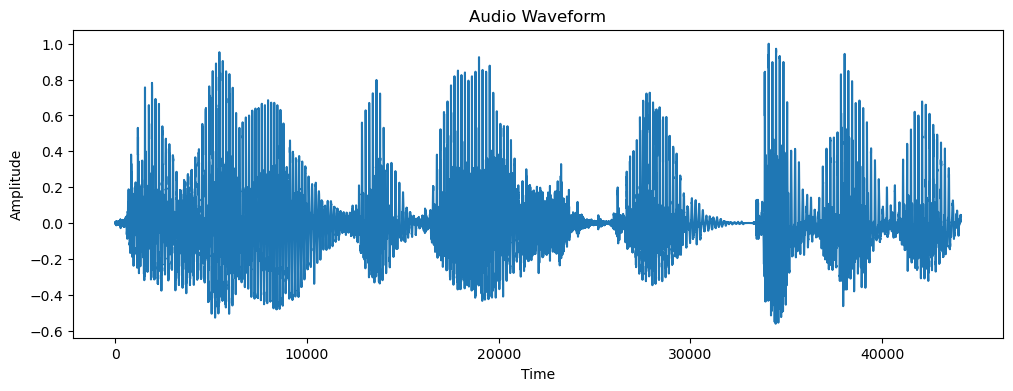

Noised Signal


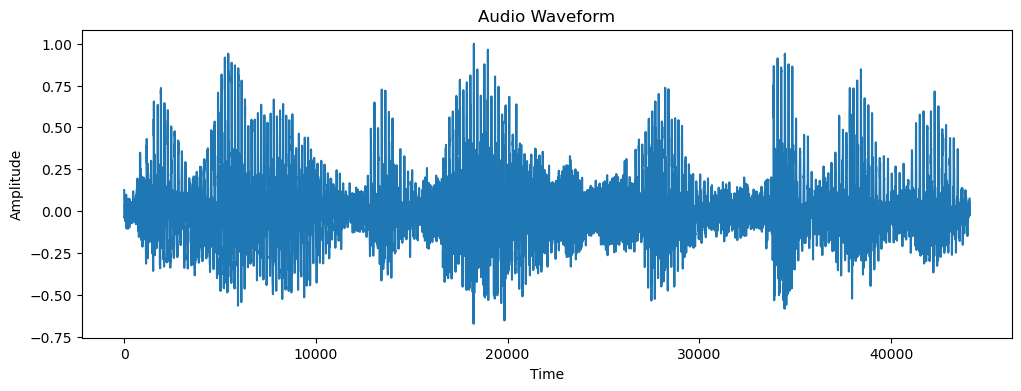

 Reconstructed signal


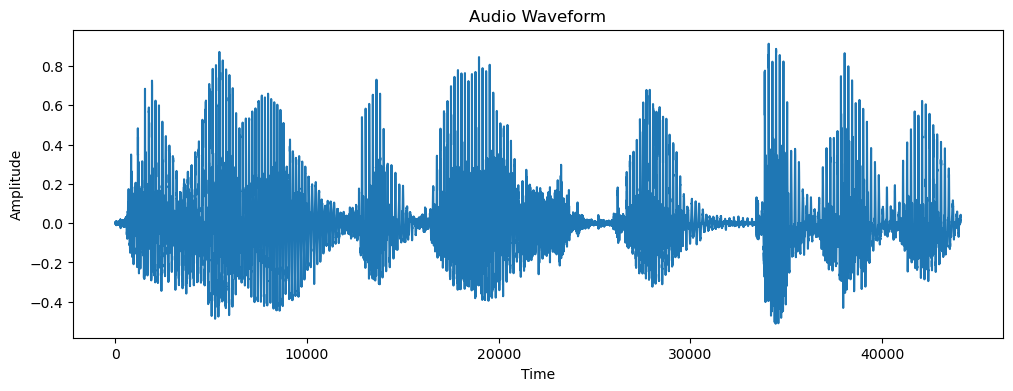



Original Signal 28


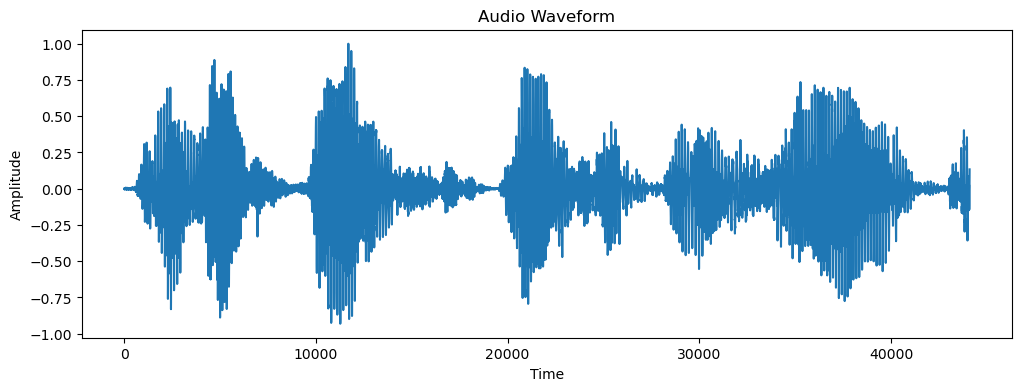

Noised Signal


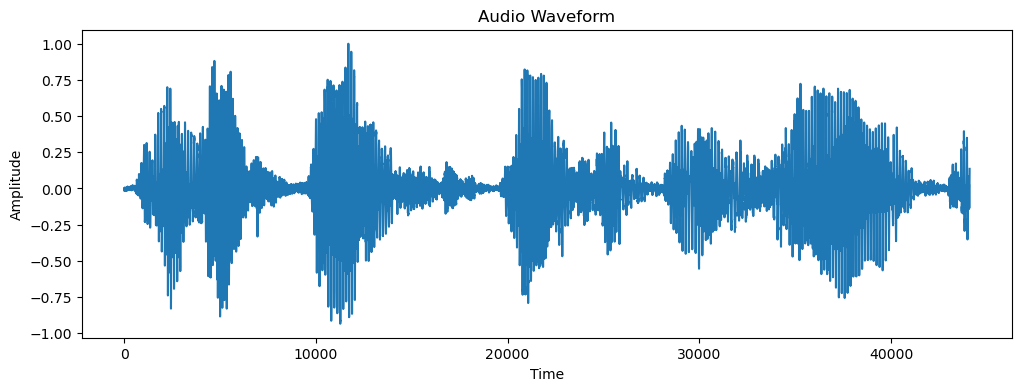

 Reconstructed signal


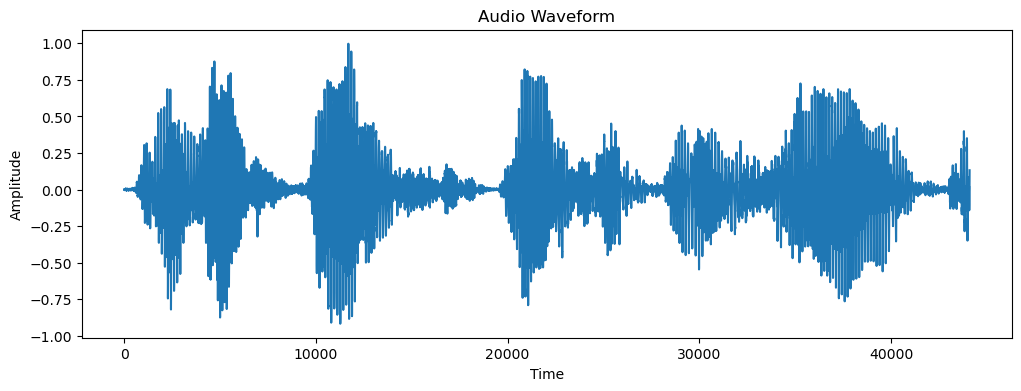

In [68]:
Num_Signal_Add_Noise = 2

for i in random.sample(best_signal_reconstruted, Num_Signal_Add_Noise):
    noised_signal = noise_adder.match_length_and_add_noise(preprocessed_audios[i], sr = None)
    reconstructed_signal = Reconstructor.reconstruct_signal(noised_signal)
    print(f"Original Signal {i}")
    visualizer = AudioVisualizer(preprocessed_audios[i])
    visualizer.show()
    print(f"Noised Signal")
    visualizer = AudioVisualizer(noised_signal)
    visualizer.show()
    print(f" Reconstructed signal")
    visualizer = AudioVisualizer(reconstructed_signal)
    visualizer.show()
    print("")
    print("")

In this scenario, the denoising process proved to be highly effective, successfully filtering out various added noises from the audio signals.

#### B) Now we add different noises to the same signal

We introduced a range of different noises to the same audio signal to evaluate the denoising process under varied auditory disturbances.

Original Signal 98


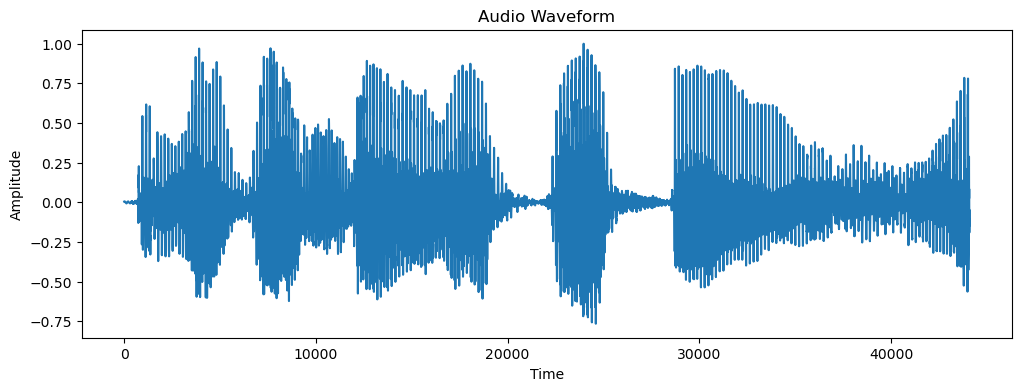

Noised version 0


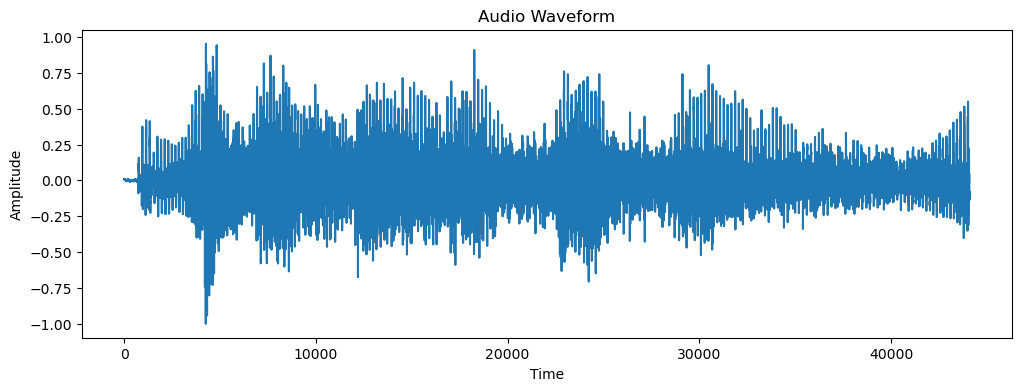

 Reconstructed of the noised version 0


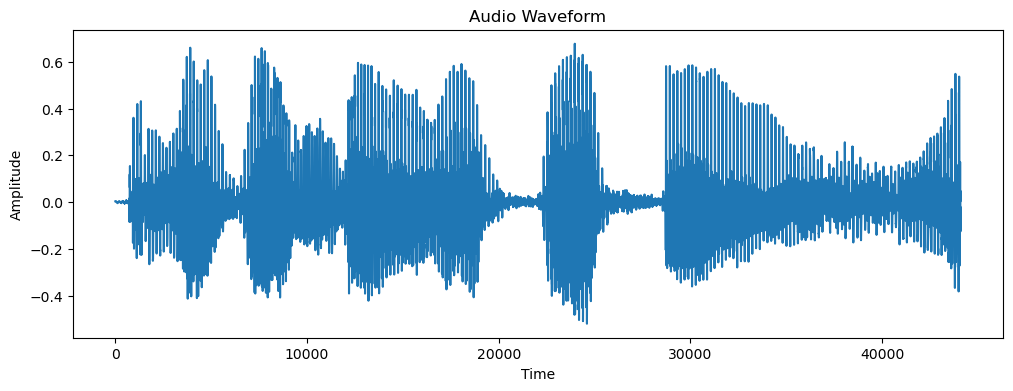



Noised version 1


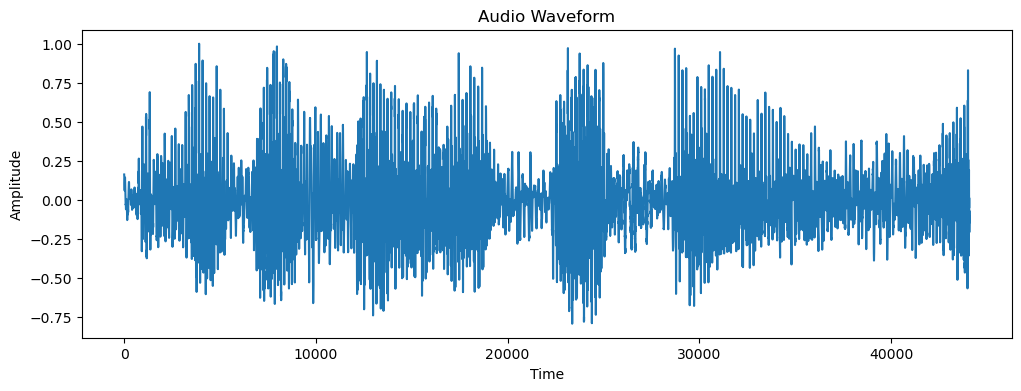

 Reconstructed of the noised version 1


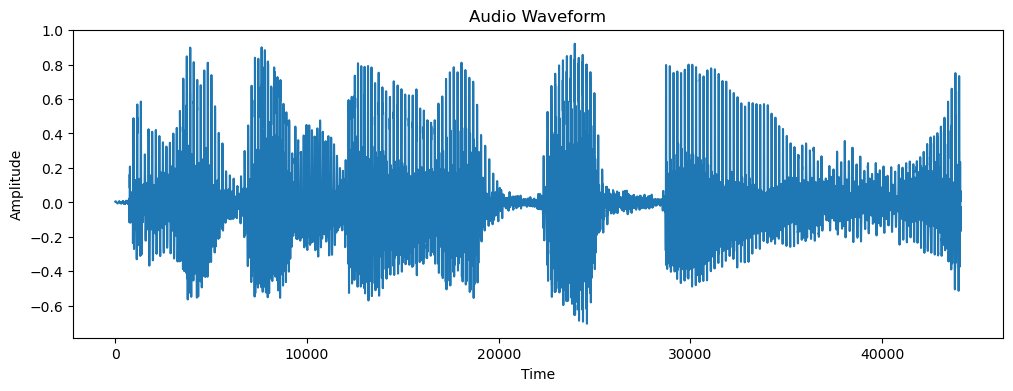



Noised version 2


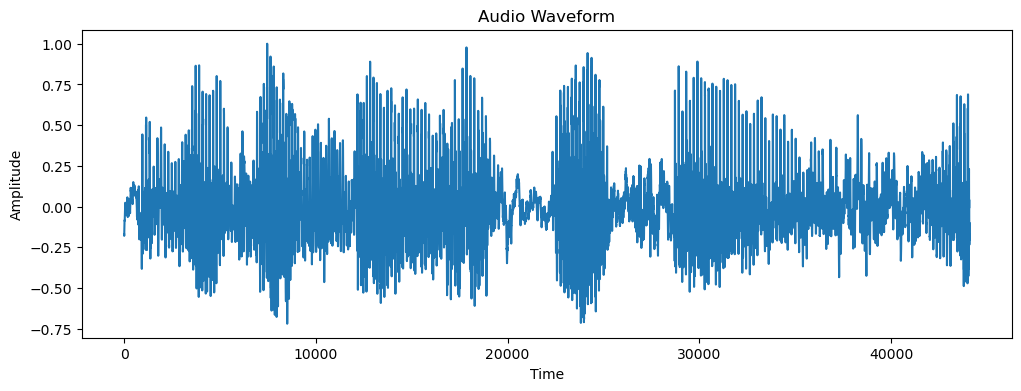

 Reconstructed of the noised version 2


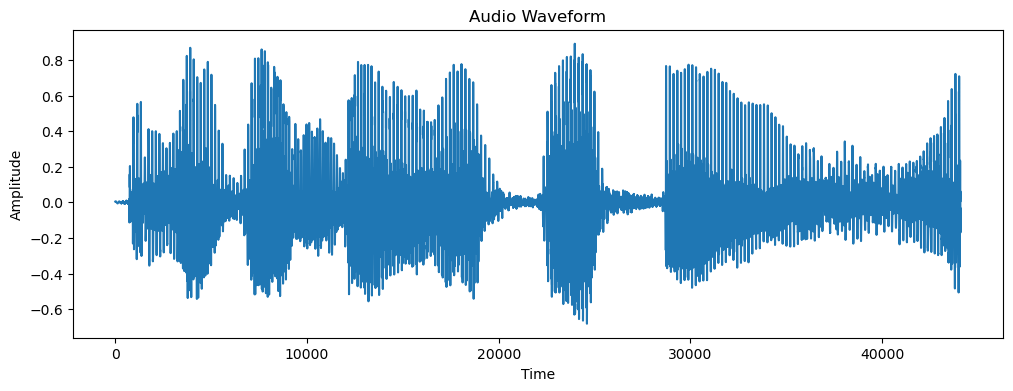

In [69]:
Num_Noise =  3
index_signal = random.sample(best_signal_reconstruted, 1)[0]

print(f"Original Signal {index_signal}")
visualizer = AudioVisualizer(preprocessed_audios[index_signal])
visualizer.show()
for i in range(Num_Noise):
    noised_signal = noise_adder.match_length_and_add_noise(preprocessed_audios[index_signal], sr = None)
    reconstructed_signal = Reconstructor.reconstruct_signal(noised_signal)
    print(f"Noised version {i}")
    visualizer = AudioVisualizer(noised_signal)
    visualizer.show()
    print(f" Reconstructed of the noised version {i}")
    visualizer = AudioVisualizer(reconstructed_signal)
    visualizer.show()
    print("")
    print("")

This approach also worked well, effectively removing different types of noise from the same audio signal.

#### C) Add multi-noise to the same signal at the same time

We introduced multiple types of noise simultaneously to the same audio signal, creating a complex noisy environment. This method tested the denoising process's ability to handle concurrent auditory disturbances within a single audio sample.

Original Signal


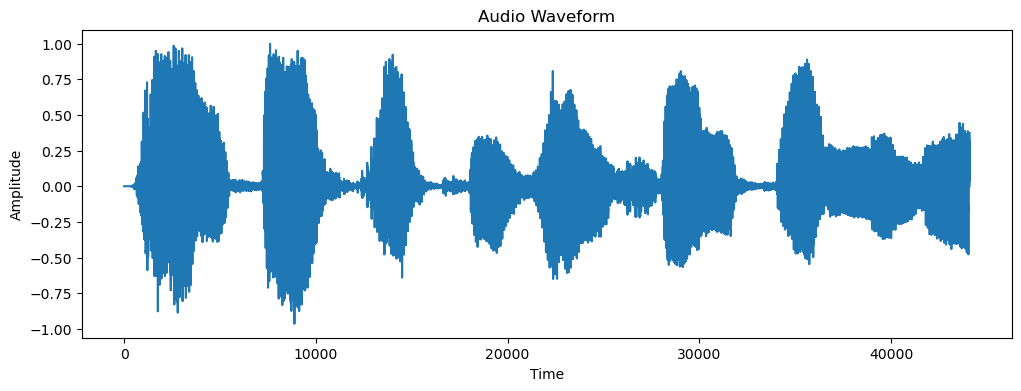

Signal with 3 different noises


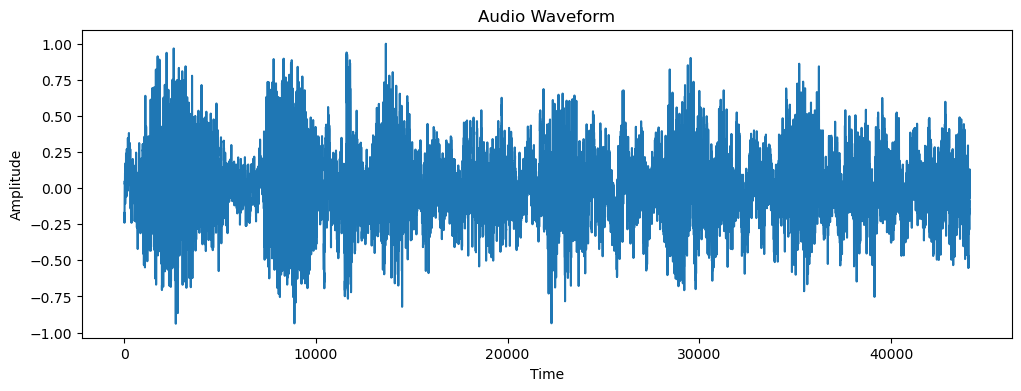

Denoised Version


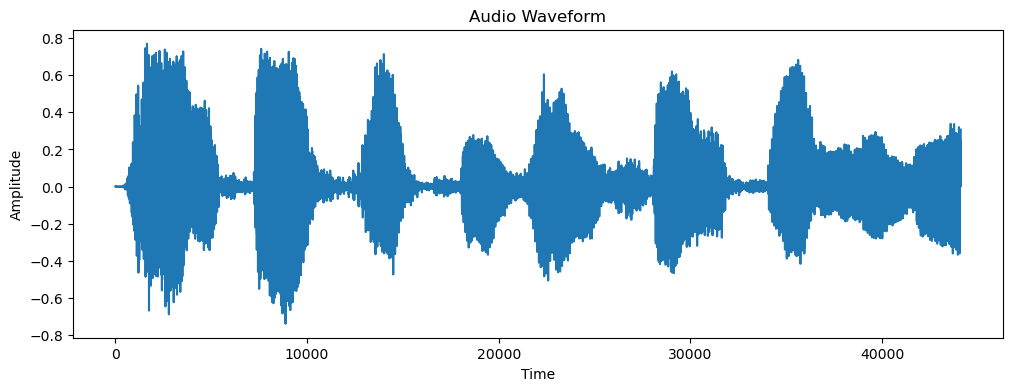

In [70]:
num_level_noise = 3
index_signal = random.sample(best_signal_reconstruted, 1)[0]
noised_signal = preprocessed_audios[index_signal]

for i in range(num_level_noise):
    noised_signal = noise_adder.match_length_and_add_noise(noised_signal, sr = None)

reconstructed_signal = Reconstructor.reconstruct_signal(noised_signal)

print(f"Original Signal")
visualizer = AudioVisualizer(preprocessed_audios[index_signal])
visualizer.show()
print(f"Signal with {num_level_noise} different noises")
visualizer = AudioVisualizer(noised_signal)
visualizer.show()
print("Denoised Version")
visualizer = AudioVisualizer(reconstructed_signal)
visualizer.show()



The denoising process demonstrated remarkable effectiveness in this complex scenario, successfully filtering out multiple concurrent noises and preserving the integrity of the original audio signal.

##### Note that the lenght of the signal (audio) doesn't have any impact on the previous resultats, to see that you can change the parameter **target_duration** when loading the train set

### II-5) Reconstruction task :  signals not part of train set

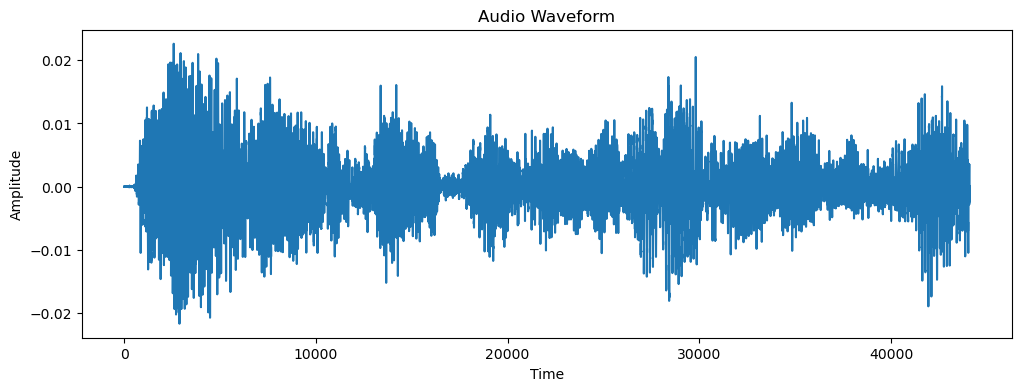

In [71]:
AudioVisualizer(dictionary[4]).show()

In [72]:
directory_path_test = 'C:\\Users\\frank\\Online dictionnary learning spard coding\\data\\cv-corpus-15.0-delta-2023-09-08\\en\\clips\\test_set'
num_samples_test = 2
preprocessor = AudioPreprocessor(directory_path_test, num_samples_test, target_duration= 2)
preprocessed_audios_test = preprocessor.preprocess_all()

Original Signal 0


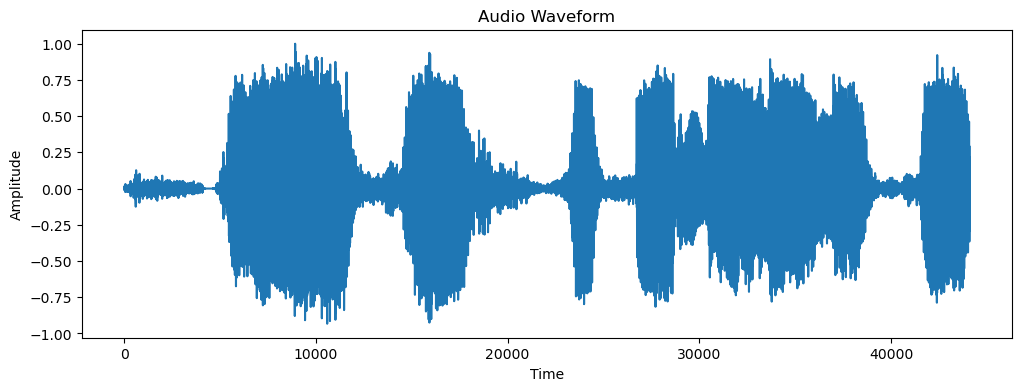

 Reconstructed signal


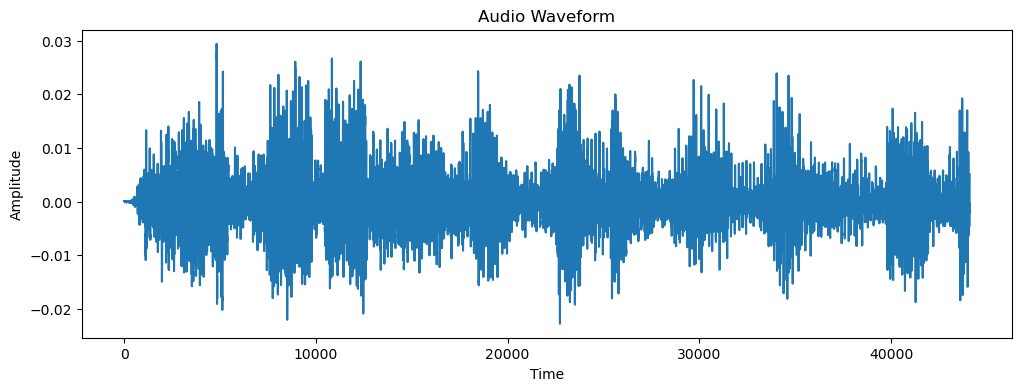



Original Signal 1


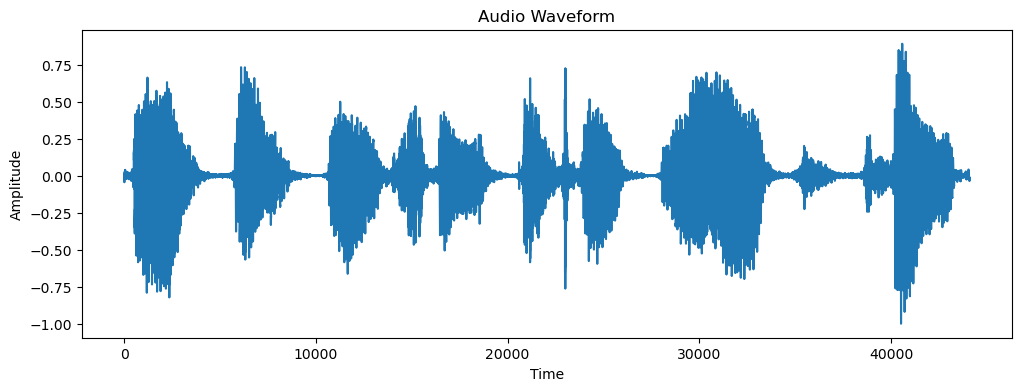

 Reconstructed signal


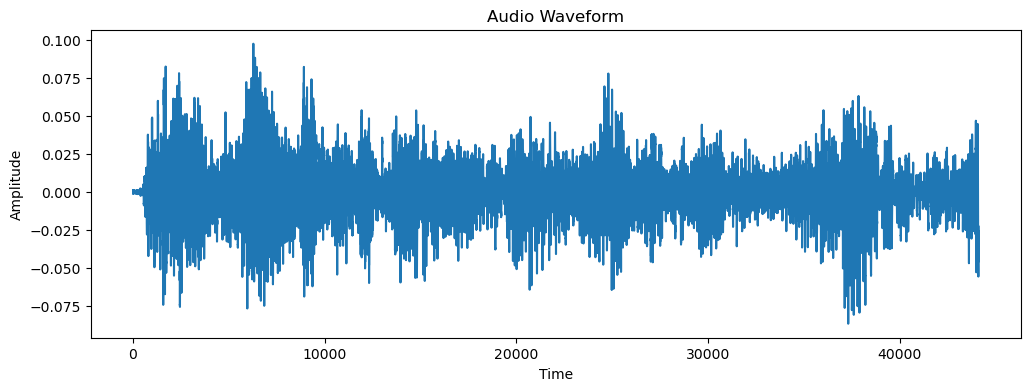

In [73]:
for i in range(num_samples_test):
    reconstructed_signal = Reconstructor.reconstruct_signal(preprocessed_audios_test[i])
    print(f"Original Signal {i}")
    visualizer = AudioVisualizer(preprocessed_audios_test[i])
    visualizer.show()
    print(f" Reconstructed signal")
    visualizer = AudioVisualizer(reconstructed_signal)
    visualizer.show()
    print("")
    print("")

In our study, the attempt to reconstruct audio signals not included in the training set proved unsuccessful. This outcome is likely due to the small sample size of our training dataset, which consisted of only 10000 audio files. Our decision to use a limited number of audio samples was necessitated by computational constraints, as training our model on a more extensive collection of audio data would require substantial computational capacity. This experience underscores the challenges in achieving effective generalization for audio reconstruction in dictionary learning, particularly when limited by the scale of training data and computational resources.